This notebook was made to test the invariance of the electronic Hamiltonian in X-SH to changes in the phase of the molecular orbitals of the diabats. This is because the band structure of a solid is made up bonding and antibonding combinations of these molecular orbitals. The phase of a given orbital does remove the occurence of both of these combinations in the band structure, where the energy and character of the bonding/antibonding combinations depends on strength of MO overlap, not MO phase.

To test this, we will vary the phase of single orbitals that are involved in CT-coupling, as well as XT-CT coupling. When changing the phase of a certain diabat's orbital, one must change the sign of all affected couplings accordingly, as the change in phase will reverse the sign of the overlap. If the correct coupling signs are reversed, the band structure of the Hamiltonian's eigenspectrum will remain constant.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import itertools

sys.path.insert(0, '/scratch/fivanovic/Work/X-SH/eigenstate_plotting')
sys.path.insert(0, '/scratch/fivanovic/Work/FOB-SH')

import XSH_eigenstates_Filip as XSF
import FOB_SH_analysis_Filip as FBA

In [2]:
def build_sim_H(H_input, dimension):
    '''
    function transcribes hamiltonian elements read in from run-pseudo-hamilt.xyz file into a corresponding numpy array

    inputs: H_input = list of lists, each element of lists is a string containing an element's magnitude and position in 
    the Hamiltonian, dimension = number of rows/columns in H matrix

    output: 2D numpy array representing electronic Hamiltonian
    '''
    
    hamiltonian = np.zeros((dimension, dimension))

    for element in H_input:

        row = int(element[0]) - 1
        column = int(element[1]) - 1
        quantity = float(element[2])

        hamiltonian[row, column] = quantity
    
    return hamiltonian

In [3]:
#Building electronic Hamiltonian from 4X4 T6-PDI system, and removing non-nearest-neighbour couplings for simplicity

H_inp = FBA.data_splitter('/scratch/fivanovic/X-SH/T6-PDI/testing_debugging/POD_T6_PDI_TEST/run-fssh-4x4/run-pseudo-hamilt-1.xyz',3)

H_sim = build_sim_H(H_inp, 20)

for index in range(len(H_sim)):
    H_sim[index][index] = H_sim[index][index]
    H_sim[index][index] = H_sim[index][index]/2

H_sim = H_sim + H_sim.T

for index in range(len(H_sim)):
    for index2 in range(len(H_sim)):

        if abs(H_sim[index][index2]) < 0.0000019596:
            H_sim[index][index2] = 0

H_sim = H_sim*27200 #converting from Hartrees to meV
sim_eigenvalues, sim_eigenvectors = XSF.get_eigen(H_sim)

First, testing the hamiltonian invariance to the change in phase of a single T6 orbital. The chosen T6 is not involved in any XT-CT coupling, so we only need to change the relevant T6-T6 couplings.

In [4]:
negative_T6_H = np.copy(H_sim)

#chosen T6 is second one in DECOMP file, so its 4 associated CT-states are in indices 4-7 in the Hamiltonian, we need
#to reverse the signs of all T6-T6 couplings in these rows

#we also need to change signs of coupling in other rows, which correspond to diabats centred on adjacent T6 molecules 
#coupling to the CT-states in 4-7

for j in range(4):

    negative_T6_H[j][j+4] = - negative_T6_H[j][j+4]
    negative_T6_H[j+4][j] = - negative_T6_H[j+4][j]

    p = j + 4
    negative_T6_H[p][p+4] = - negative_T6_H[p][p+4]
    negative_T6_H[p+4][p] = - negative_T6_H[p+4][p]

    negative_T6_H[p][p+8] = - negative_T6_H[p][p+8]
    negative_T6_H[p+8][p] = - negative_T6_H[p+8][p]

negative_T6_eigenvalues, negative_T6_eigenvectors = XSF.get_eigen(negative_T6_H)

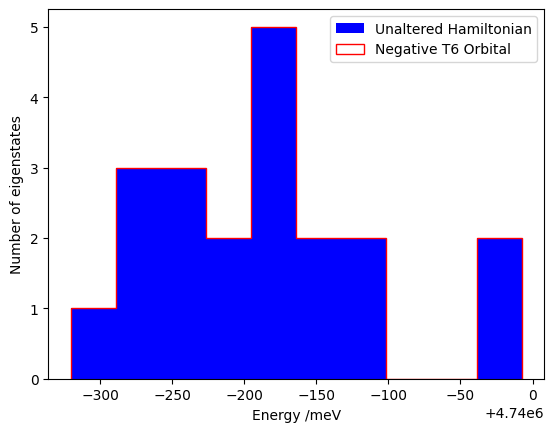

In [5]:
plt.hist(sim_eigenvalues, color = 'b', label = 'Unaltered Hamiltonian')
plt.hist(negative_T6_eigenvalues, color = 'r', alpha = 1, histtype = 'step', label = 'Negative T6 Orbital')
plt.xlabel('Energy /meV')
plt.ylabel('Number of eigenstates')
plt.legend()

In [6]:
#here, we change i the sign of a non-interfacial PDI orbital to test the sign-invariance of the Hamiltonian wrt PDI-PDI 
#electron coupling

#as before, we change the sign of PDI-PDI couplings involving this particular molecule only

negative_PDI_H = np.copy(H_sim)

for j2 in range(3,16,4):
    #j2 is indexing the rows where the diabat is centred on the far-right PDI molecule and a particular T6 molecule

    for p2 in range(j2-3, j2):
        #p2 then indexes the other 3 diabats centred on the same T6 but the other 3 PDI's - these couplings need to be reversed

        negative_PDI_H[j2][p2] = - negative_PDI_H[j2][p2]
        negative_PDI_H[p2][j2] = - negative_PDI_H[p2][j2]

negative_PDI_eigenvalues, negative_PDI_eigenvectors = XSF.get_eigen(negative_PDI_H)
#we don't need to focus on rows other than where the diabats centred on the chosen PDI are, as the Hamiltonain is indexed
#such that diabats on different PDI molecules are next to eachother in the Hamiltonian

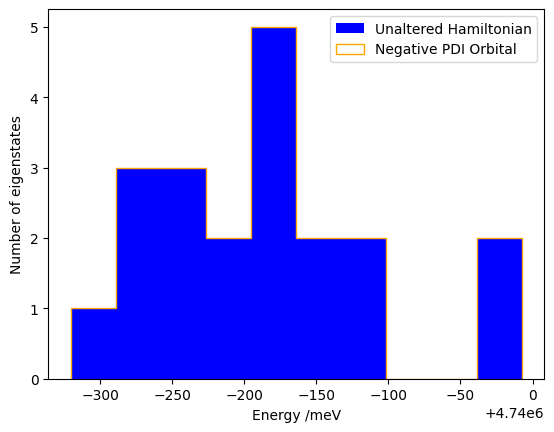

In [7]:
plt.hist(sim_eigenvalues, color = 'b', label = 'Unaltered Hamiltonian')
plt.hist(negative_PDI_eigenvalues, color = 'orange', alpha = 1, histtype = 'step', label = 'Negative PDI Orbital')
plt.xlabel('Energy /meV')
plt.ylabel('Number of eigenstates')
plt.legend()

The eigenspectra of the electronic Hamiltonian are invariant to phase changes in both the donor and acceptor phase. This implies that the determination of the signs of the couplings at the beginning of the X-SH simulation are consistent, when it comes to which orbital phases are selected for each mode of coupling.

Samuele tested the invariance for the XT-block and found the same result. Now, we will move on to changing the interfacial coupling sign via changing the phase of a HOMO on an interfacial T6 molecule.

In a 1D system, changing the XT-CT on its own should not change the eigenspectrum. This is because the phases of the T6 HOMOs are not constrained by anything, so changing the sign of the XT-CT sign through reversing the phase of the interfacial T6 HOMO, should not change the signs of the other T6-T6 couplings since we can just define the phases of the remaining T6 HOMOs to be such that the coupling signs remain the same. For PDI, this is not the case, as the HOMO and LUMO phases are constrained by the relative signs of the TrESP and electron-electron couplings.

In [8]:
#therefore we define a 1D chain of T6-PDI with nearest-neighbour couplings only, all parameters of the Hamiltonian
#are the same apart from the sign of the XT-CT coupling

vec = XSF.build_lattice(100, 1, 5)
dons, accs = XSF.DA_index(vec, 50)
conns = XSF.build_connectivity(vec, 5)
CT_states = XSF.define_CT_states(dons, accs)
H_CT = XSF.build_CT_block(CT_states, vec, conns, -320, -20.7, 45.5, -1e-3)
#H_CT = H_CT - np.diag(np.ones(len(H_CT)))*H_CT[6][6]

XT_states = XSF.define_XT_states(accs)
H_XT = XSF.build_XT_block(XT_states, conns, 0.1, 85.7)

H_XT_CT = XSF.build_XT_CT_block(XT_states, CT_states, conns, -31.8)
H_XT_CT_switched = XSF.build_XT_CT_block(XT_states, CT_states, conns, 31.8)

full_H = XSF.build_full_Hamiltonian(H_CT, H_XT, H_XT_CT)
full_H_switched = XSF.build_full_Hamiltonian(H_CT, H_XT, H_XT_CT_switched)

eigenvals, eigenvecs = XSF.get_eigen(full_H)
eigenvals_switched, eigenvecs_switched = XSF.get_eigen(full_H_switched)

#we obtain the eigenspectra of the two Hamiltonians with different XT-CT coupling signs

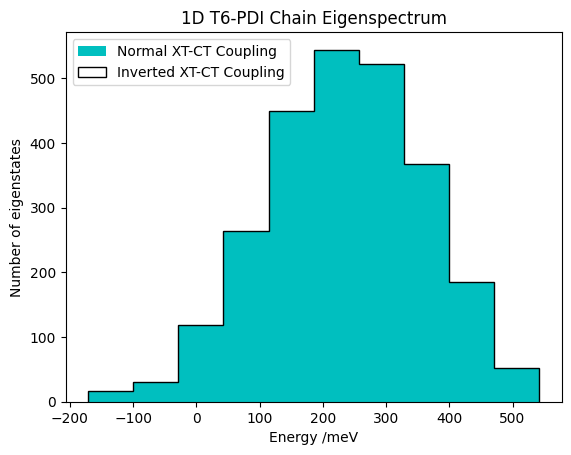

In [16]:
plt.hist(eigenvals, color = 'c', label = 'Normal XT-CT Coupling')
plt.hist(eigenvals_switched, color = 'k', alpha = 1, histtype = 'step', label = 'Inverted XT-CT Coupling')
plt.xlabel('Energy /meV')
plt.ylabel('Number of eigenstates')
plt.title('1D T6-PDI Chain Eigenspectrum')
plt.legend()

#and they are the same, as expected

Now doing this but for an actual X-SH hamiltonian for a 3x3 T6-PDI interface. The difference here is that the couplings are not restricted to nearest neighbours, but are instead controlled by a distance cutoff. This means that there are some very small XT-CT couplings between interfacial molecules and those once-removed from the interface. If we change a HOMO on a T6 molecule at the interface, all corresponding interfacial couplings must also change.

In [10]:
H_inp_3x3 = FBA.data_splitter('/scratch/fivanovic/Work/X-SH/check_X-SH/T6_PDI_H_step1_shortTRESP.xyz',3)
H_sim_3x3 = build_sim_H(H_inp_3x3, 12)

for index in range(len(H_sim_3x3)):
    H_sim_3x3[index][index] = H_sim_3x3[index][index]
    H_sim_3x3[index][index] = H_sim_3x3[index][index]/2

H_sim_3x3 = H_sim_3x3 + H_sim_3x3.T
H_sim_3x3_switched = np.copy(H_sim_3x3)

H_sim_3x3_switched[:9, 9:] = -H_sim_3x3[:9, 9:]
H_sim_3x3_switched[9:, :9] = -H_sim_3x3[9:, :9]

eigenvals_3x3, eigenvecs_3x3 = XSF.get_eigen(H_sim_3x3)
eigenvals_3x3_switched, eigenvecs_3x3_switched = XSF.get_eigen(H_sim_3x3_switched)

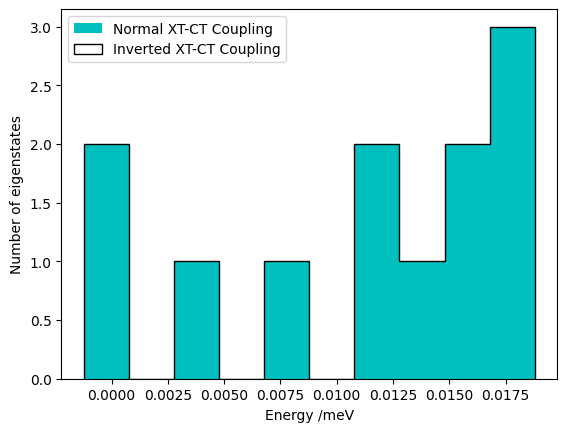

In [ ]:
plt.hist(eigenvals_3x3, color = 'c', label = 'Normal XT-CT Coupling')
plt.hist(eigenvals_3x3_switched, color = 'k', alpha = 1, histtype = 'step', label = 'Inverted XT-CT Coupling')
plt.xlabel('Energy /meV')
plt.ylabel('Number of eigenstates')
plt.legend()

#fortunately, we observe that the X-SH hamiltonian in a 1D system with non-nearest-neighbour couplings, it is also
#invariant to the XT-CT coupling changing sign

However, for a 2D system, the Hamiltonian is not invariant with respect to a signle XT-CT coupling changing sign. This is becasue the phases of the interfacial HOMOs are fixed as soon as the sign of the XT-CT coupling is set. Although the HOMO phases of the non-interfacial T6 molecules are still arbitrary, the HOMOs of adjacent interfacial T6 molecules, which did not coexist in a 1D system (obviously), are not. A change in XT-CT sign means one of the interfacial HOMOs changes phase, which will also change the sign of an coupling term between T6 HOMO's located on the interface.

This means that just changing a single XT-CT coupling term will change the eigenspectrum.

Text(0, 0.5, 'Number of eigenstates')

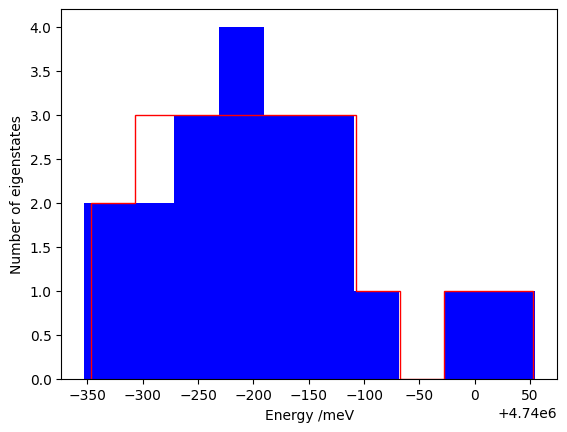

In [12]:
amplified_H = np.copy(H_sim)

#taking the same Hamiltonian for a 4x4 system, and amplifying the XT-CT block to make the difference in eigenspectra more
#visible
amplified_H[:16, 16:] = 5*amplified_H[:16, 16:]
amplified_H[16:, :16] = 5*amplified_H[16:, :16]

incorrect_interfacial_H = np.copy(amplified_H)
incorrect_interfacial_H[0][-4] = - incorrect_interfacial_H[0][-4]
incorrect_interfacial_H[-4][0] = - incorrect_interfacial_H[-4][0]
#changing the XT-CT coupling associated with the first diabat, and no other matrix elements

amplified_eigenvals, amplified_eigenvecs = XSF.get_eigen(amplified_H)
incorrect_interfacial_eigenvals, incorrect_interfacial_eigenvecs = XSF.get_eigen(incorrect_interfacial_H)

plt.hist(amplified_eigenvals, color = 'b', label = 'Unaltered H')
plt.hist(incorrect_interfacial_eigenvals, color = 'r', alpha = 1, histtype = 'step', label = 'Single XT-CT Inverted')
plt.xlabel('Energy /meV')
plt.ylabel('Number of eigenstates')
#plt.title('4:4 2D Interface Eigenspectrum')
#plt.legend()

#plotting the original (but amplified) Hamiltonian with the incorrectly switched one does indeed change the eigenspectrum

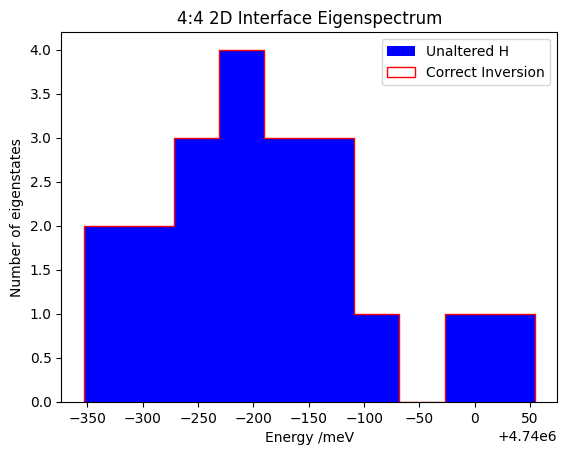

In [13]:
#doing the same, but now changing the T6 h-h coupling signs as a result of reversing the sign of a single interfacial T6
#molecule, recovers the sign-invariance of the Hamiltonian

for j in range(4):

    number_CT = 16
    coupling_list = [j+4, j+8, j+12]

    for element in coupling_list:

        incorrect_interfacial_H[j][element] = -incorrect_interfacial_H[j][element]
        incorrect_interfacial_H[element][j] = -incorrect_interfacial_H[element][j]
        
corrected_interfacial_eigenvals, corrected_interfacial_eigenvecs = XSF.get_eigen(incorrect_interfacial_H)

plt.hist(amplified_eigenvals, color = 'b', label = 'Unaltered H')
plt.hist(corrected_interfacial_eigenvals, color = 'r', alpha = 1, histtype = 'step', label = 'Correct Inversion')
plt.xlabel('Energy /meV')
plt.ylabel('Number of eigenstates')
plt.title('4:4 2D Interface Eigenspectrum')
plt.legend()

Now, I want to compare the X-SH overlap values for an interfacial T6-PDI dimer, with the corresponding POD values of these dimers' h-h couplings. I have taken the POD couplings straight from the output files of the POD calculations, and just copied them into a numpy array here. I have done the same for the X-SH overlaps, that were this time calculated with pyAOM. This shouldn't make a difference to doing it with X-SH, as we have already shown a perfect agreement between the two codes in the past.

The quality of the linear relationship is similar to that of the T6-T6 coupling, since the interfacial coupling will also be affected by the torional flexibility of the T6 molecule.

What we also intend to do is examine the relationship between the signed X-SH/pyAOM overlaps and the signed POD couplings. Although the orbital phases of the POD couplings are arbitrary, other group members have previously observed a negative correlation between these two quantities. We also observe that here, which means that the workflow I use to extract the couplings and overlaps likely doesn't have any issues.

The POD coupling values are in the POD_TEST directory in my storage, inside the 'interface-sign-check' directory. The pyAOM couplings can be obtained just by running the pyAOM script inside the 'hamiltonian_sign_check/check_pyAOM' directory.

Text(0.5, 1.0, 'pyAOM Overlap vs POD Coupling')

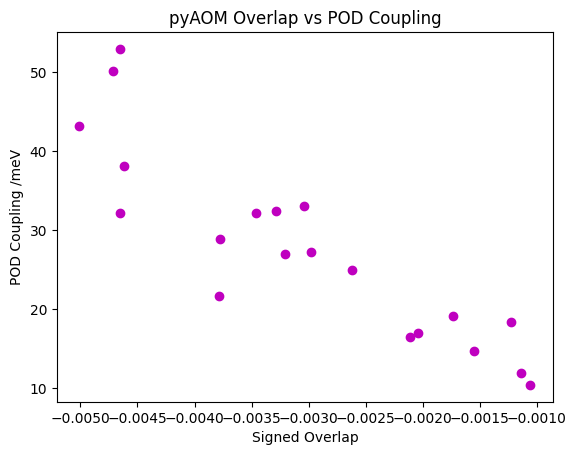

In [14]:
interfacial_POD_couplings = np.array([-20.5683 ,  24.4596 , -24.2477 , -24.991  ,  18.8745 ,  21.8257 ,
        39.9781 ,  24.3305 , -16.3522 , -20.3772 ,  12.4262 ,  -8.9695 ,
       -11.1005 ,  14.4523 , -32.6537 ,  37.8976 ,  28.8224 ,  12.7747 ,
         7.84514, -13.8781 ])

adjusted_POD_couplings = abs(interfacial_POD_couplings)*1.325

interfacial_pyAOM_overlaps = np.array([-0.002975702308820485, -0.0032826141124352843, -0.004650577866389515, -0.0030438910012120343, -0.00261984601806696, -0.003773066361781499, 
-0.004652439076894729, -0.003462877602425633, -0.0037811786882694367, -0.0032097107034649817, -0.0021070981968544264, -0.001141573460429618, -0.0015527015853080497, -0.0017328631018829993, -0.0050086775279579885, -0.004710732479353104, -0.004617222268750344, -0.002038212844388968, -0.001055938247280797, -0.0012227720599590093])

plt.scatter(interfacial_pyAOM_overlaps , adjusted_POD_couplings, color = 'm')
plt.ylabel('POD Coupling /meV')
plt.xlabel('Signed Overlap')
plt.title('pyAOM Overlap vs POD Coupling')

Text(0.001, 45, 'C = 9459 meV')

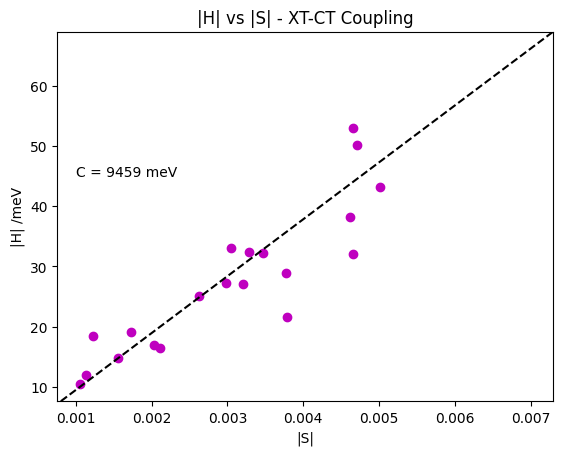

In [15]:
plt.scatter(abs(interfacial_pyAOM_overlaps) , adjusted_POD_couplings, color = 'm')
plt.axline((0.003,28.377),(0.007,66.213), color = 'k', linestyle = 'dashed')
plt.ylabel('|H| /meV')
plt.xlabel('|S|')
plt.title('|H| vs |S| - XT-CT Coupling')
plt.text(0.001, 45, 'C = 9459 meV')